# Install ASE

with modifications for symmetrized surfaces

In [1]:
import subprocess
import sys
try:
    sys.path.insert(0,'/data/git/ase/')
except FileNotFoundError as E:
    pass
try:
    import ase
except ModuleNotFoundError as E:
    subprocess.check_call([sys.executable, '-m','pip','install','git+https://gitlab.com/mdforti/ase.git'])
    import ase

# Load Machinery for google drive


In [2]:
import os
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except Exception as E:
    pass
    
if os.path.exists('/content/drive'):
  pathtofiles='/content/drive/Shareddrives/Tenacidad_Zr-ZrO2/'
else:
  pathtofiles=os.getcwd()
if pathtofiles is not os.getcwd():
  os.chdir(pathtofiles)

# load ASE 

In [3]:

from ase.io.vasp import read_vasp
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.build import surface, make_supercell
from ase.build.surfaces_with_termination import surfaces_with_termination, atom_index_in_top, atom_index_in_bottom
from ase.geometry import get_layers
from ase.build import bulk, hcp10m10, hcp0001
from ase.build import stack
from ase.io import write
from ase.io.vasp import write_vasp
from ase import Atoms
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(25,10))
import numpy as np

In [4]:
zro2 = read_vasp('Structure/POSCAR')

In [5]:
def plotviews(atoms_object,
              rotation1='-90x',
              rotation2='-90x, 45y',
              rotation3='0x'):
  fig = plt.figure()
  ax1 = fig.add_axes((0.1,0.1, 0.3,0.8))
  ax2 = fig.add_axes((0.3,0.1, 0.3,0.8))
  ax3 = fig.add_axes((0.6,0.1, 0.3,0.8))
  plot_atoms(atoms_object,rotation=rotation1, ax=ax1)
  plot_atoms(atoms_object,rotation=rotation2, ax=ax2)
  plot_atoms(atoms_object,rotation=rotation3,ax=ax3)
  return ax1, ax2, ax3

# Objetivo

lo primero que quiero hacer es reconstruir la interfaz de paula:

In [6]:
intf=read_vasp('Interfaces/POSCAR_primero.vasp')

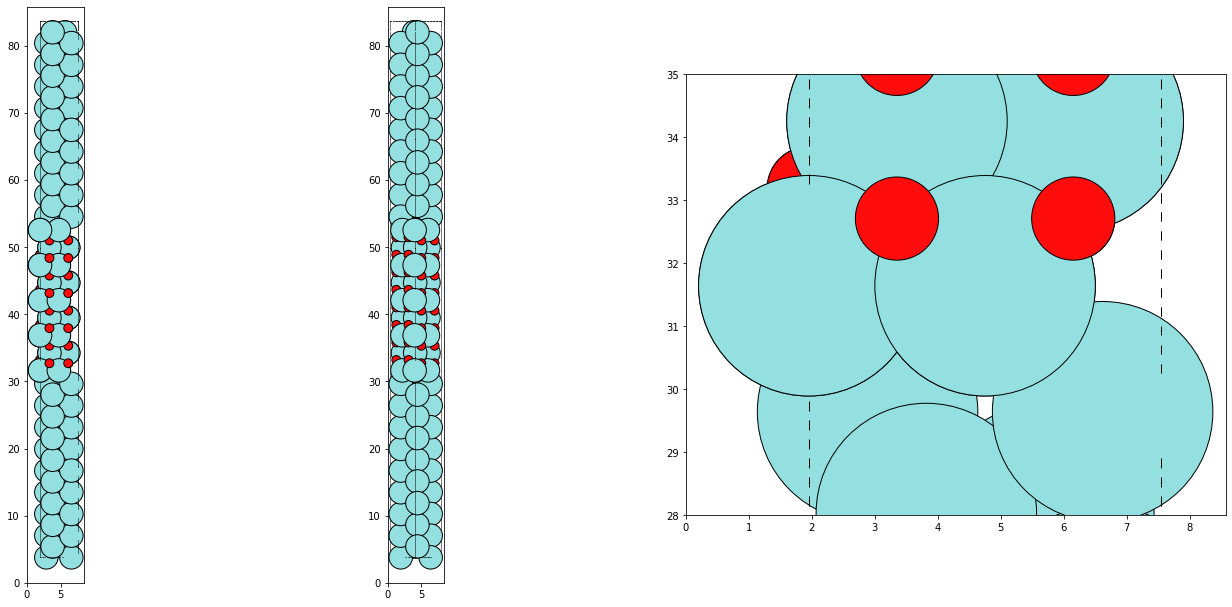

In [7]:
ax1, ax2, ax3 = plotviews(intf, rotation3='-90x')
ax3.set_ylim([28,35])
fig = plt.gcf()

- observamos que con esos parámetros de red la ZrO<sub>2</sub> está muy comprimida (casi el 30%, hay dos celdas en el slab de óxido)
- observamos que la terminación de la zr debe ser O(valle) , mientras que la que está ahí calculada es Zr.
- a demás hay demasiados átomos!

respecto de esa última observación, tomamos en VESTA la siguiente estructura:

In [8]:
intf_red = read_vasp('Interfaces/POSCAR_reducido.vasp')

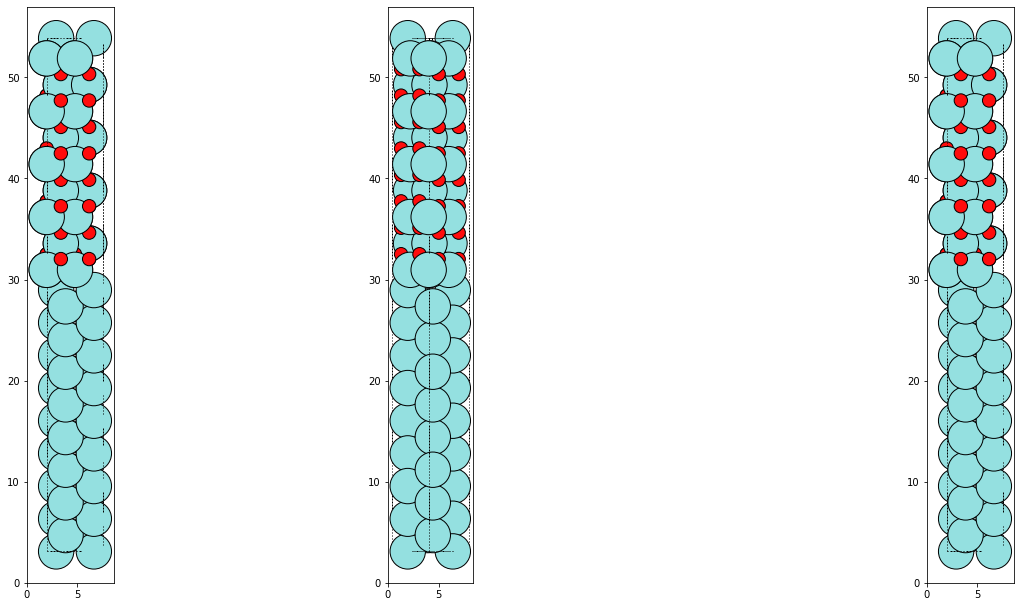

In [9]:
ax1, ax2, ax3 = plotviews(intf_red, rotation3='-90x')

# Superficies

## ZrO2

tratamos de hacer las superficie que a paula le dió mas estable

primero genero la superficie de ZrO<sub>2</sub>

para tener la superficie mas estable y simétrica, hay que sacar algunos átmos:
- los oxígenos de la ceresta
- los zr de la tapa de abajo

# Superficies con terminacion con ASE

In [10]:
ZrO2001Oterm = surfaces_with_termination(zro2, [0,0,1],layers=4, vacuum=15., termination='O',verbose=True, symmetric=True)
[write_vasp(f'ZrO2001_1x1_{i}.vasp', thisone, sort=True, direct=True) for i, thisone in enumerate(ZrO2001Oterm)]

([4], ['Zr']) ([20], ['O'])
([3], ['O']) ([18], ['O'])
([5], ['Zr']) ([21], ['O'])
([2], ['O']) ([19], ['O'])


[None, None, None, None]

In [11]:
ZrO2001Zrterm = surfaces_with_termination(zro2, [0,0,1], 5, vacuum=10., termination='Zr')

In [12]:
# [ plotviews(this) for this in ZrO2001Oterm]

In [13]:
ZrO2001_2x2 = [make_supercell(ZrO2001Oterm[i],[[2,0,0],[0,2,0],[0,0,1]],tol=1e-10, wrap=True) for i in range(len(ZrO2001Oterm))]
translate = [this.translate([this[0].x]) for this in ZrO2001_2x2]
[this.write(f'ZrO2001_2x2_{i}.vasp',sort=True, direct=True, format='vasp') for i,this in enumerate(ZrO2001_2x2)]

[None, None, None, None]

la que corresponde con el modelo de Paula es la última, pero para que quede igual hay que hacerle una trasación todavía:

[(<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>)]

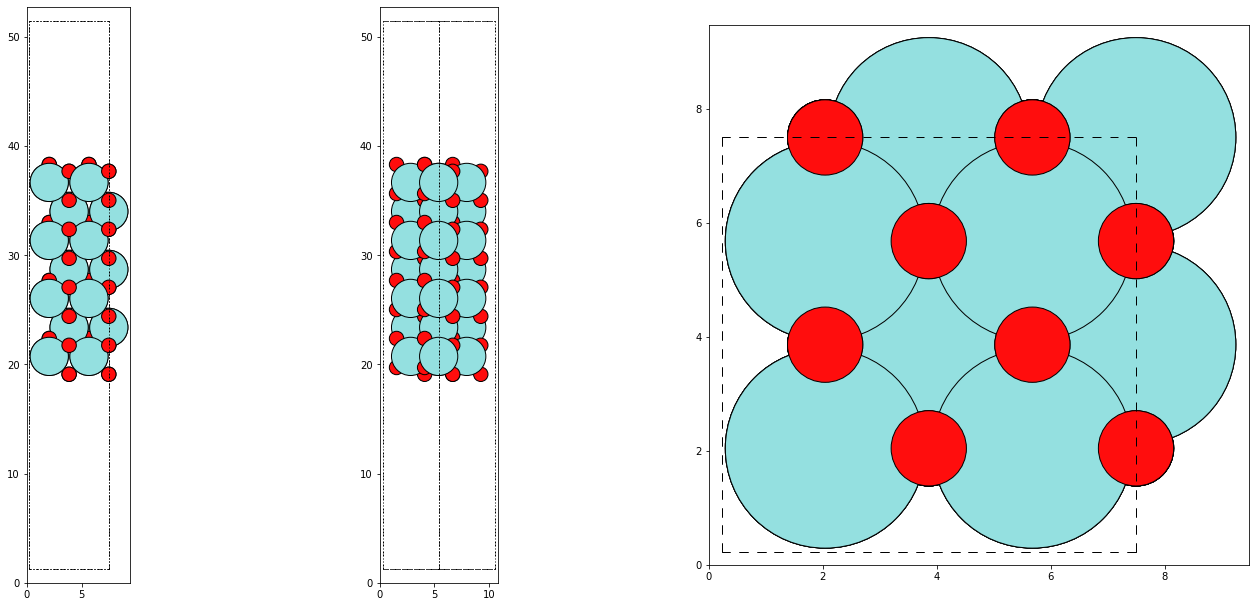

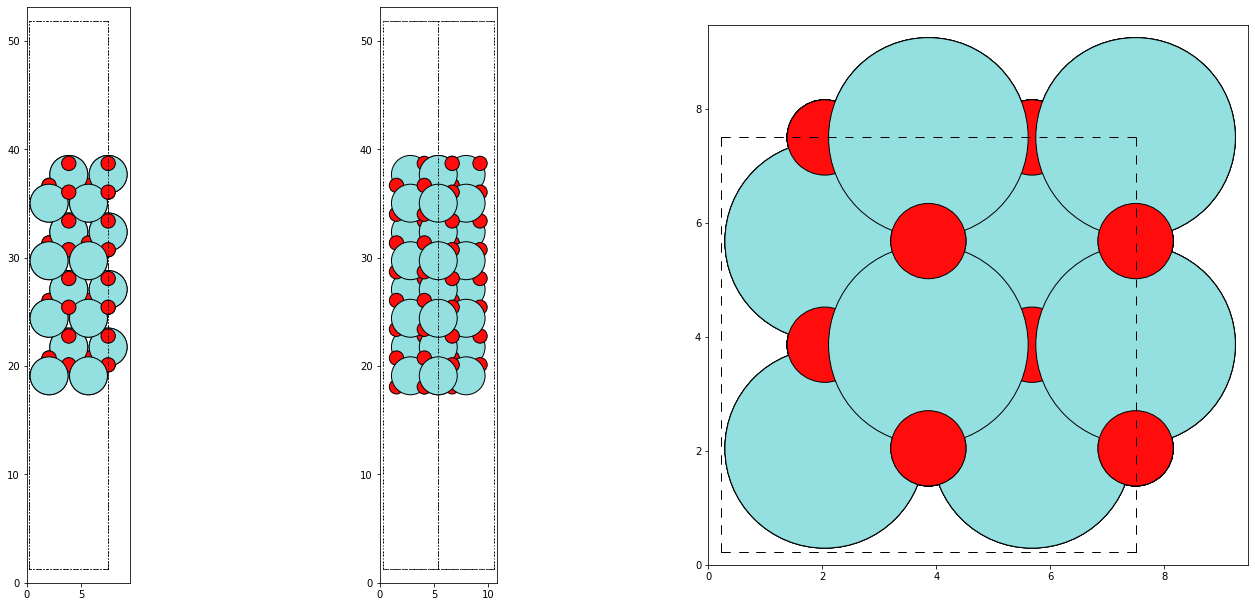

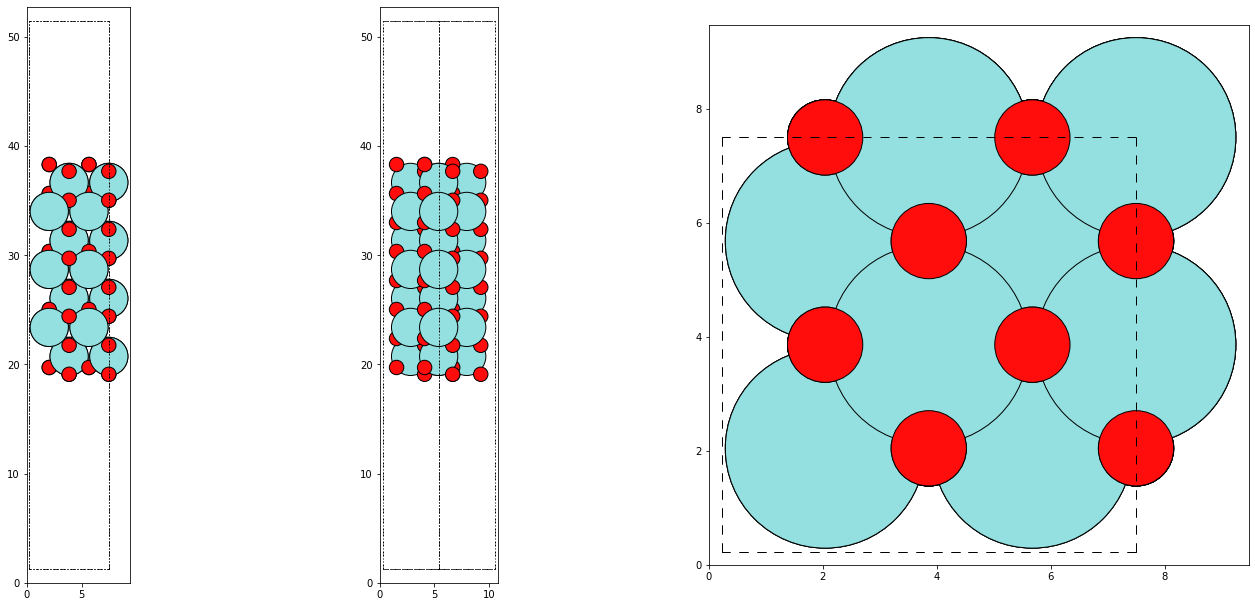

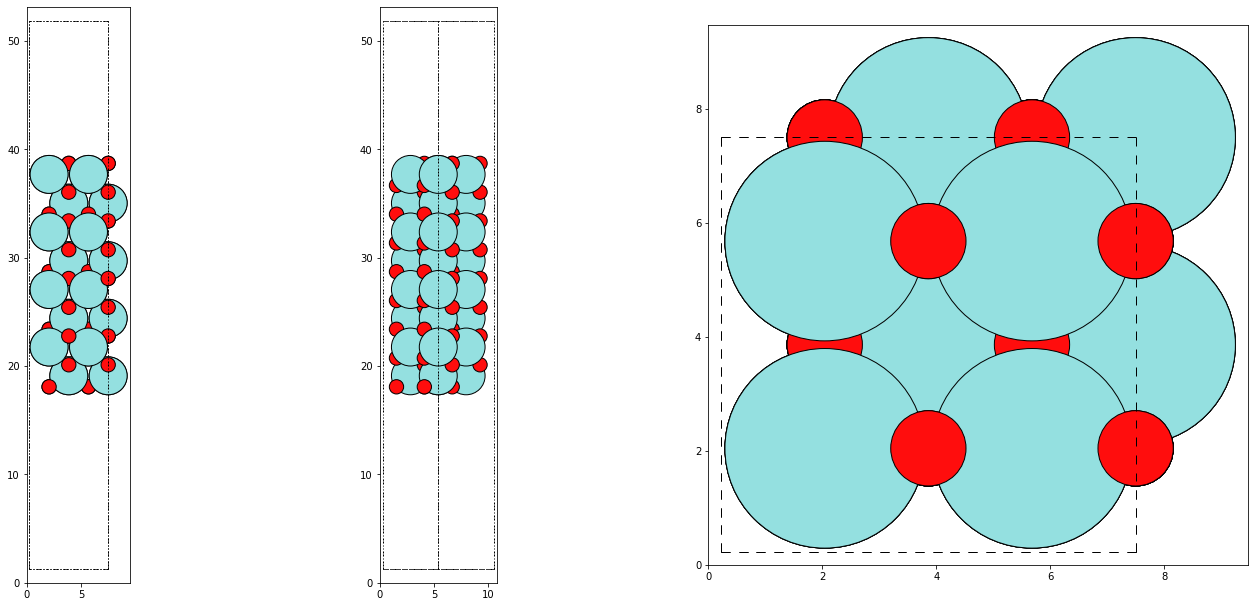

In [14]:
[ plotviews(this) for this in ZrO2001_2x2]

## circonium

In [15]:
def remove_bottom_atom(theatoms):
    atoms = theatoms.copy()
    layers, hs = get_layers(atoms,(0,0,1))
    atoms_in_bottom = atom_index_in_bottom(layers)
    atoms.pop(atoms_in_bottom[-1])
    return atoms

In [16]:
zrhcpa = 3.2313 # Zr.cell[0][0]
zrhcpc = 5.1479 # Zr.cell[-1][-1]

zrhcp = bulk('Zr',crystalstructure='hcp',a=zrhcpa, c = zrhcpc,orthorhombic=True)

(<Axes:>, <Axes:>, <Axes:>)

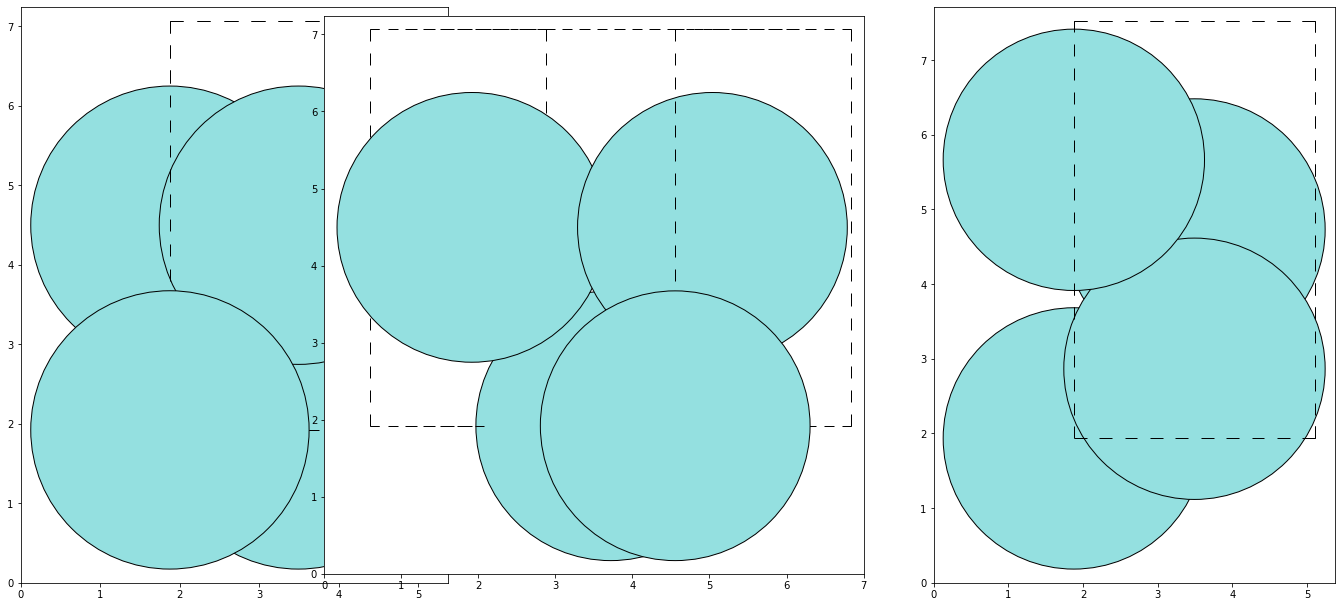

In [17]:
plotviews(zrhcp)

for hexagonal lattices, the equivalence to make the correct surfaces is :
- (0 0 0 1): (0 0 1)
- (1 0 -1 0): (1 0 0)
- (1 1 -2 0): (1 1 0)

In [18]:
from ase.build.surfaces_with_termination import (atom_index_in_bottom, atom_index_in_top)

now i want to remove the bottom layer, so bottoma nd top have same symmetry

In [19]:
## Zr0001

Zr0001 = surfaces_with_termination(zrhcp, (0,0,1), 4, vacuum=10, termination='Zr')[0]
#Zr0001.pop(atoms_in_bottom[-1])

(<Axes:>, <Axes:>, <Axes:>)

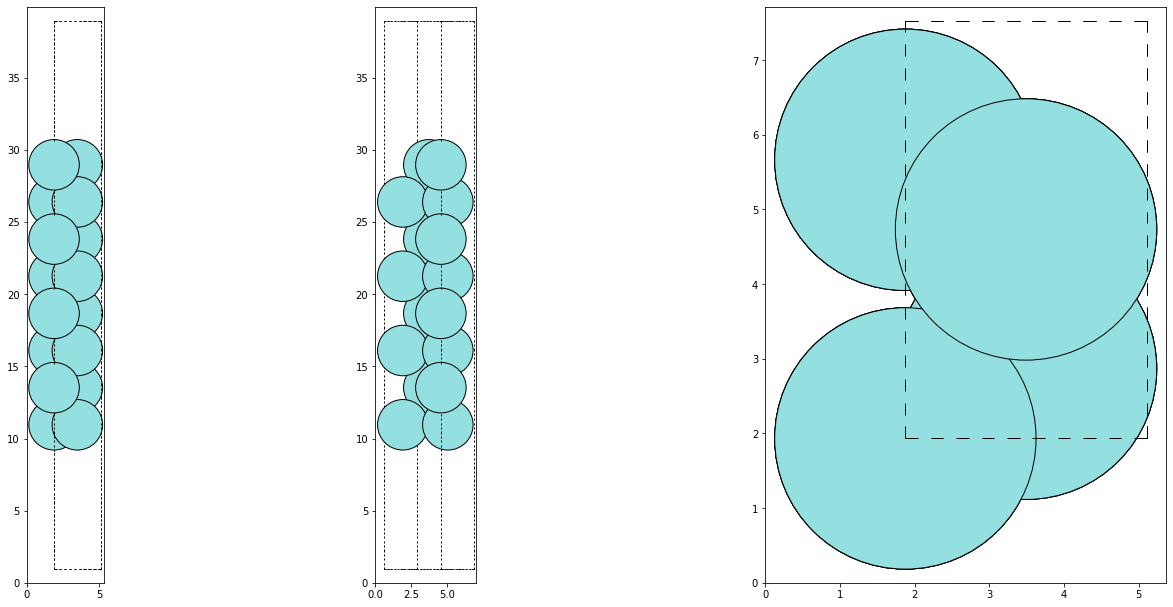

In [20]:
plotviews(Zr0001)

In [21]:
Zr0001_2x2=make_supercell(Zr0001, [[2,0,0],[0,1,0],[0,0,1]],)
Zr0001_2x2.write('Zr0001_2x2.vasp',sort=True,wrap=True, direct=True,vasp5=True)

(<Axes:>, <Axes:>, <Axes:>)

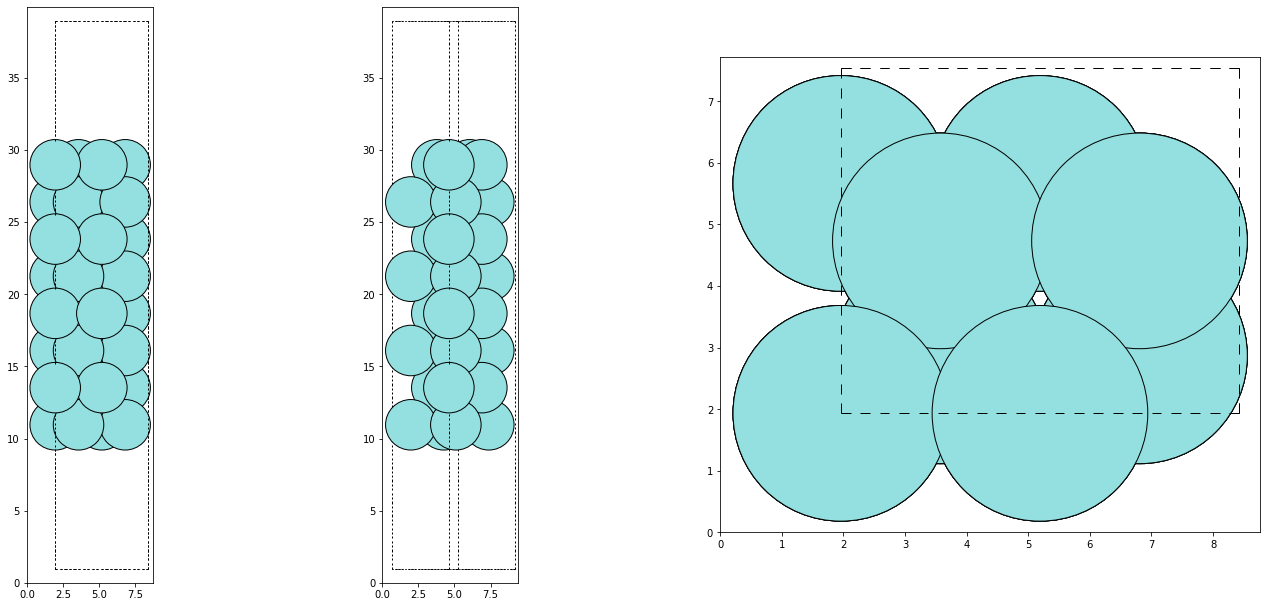

In [22]:
plotviews(Zr0001_2x2)

## 10-10

In [23]:
Zr0101=surfaces_with_termination(zrhcp,(1,0,0),7, vacuum=10)[0]
Zr0101 = remove_bottom_atom(Zr0101)
Zr0101 = remove_bottom_atom(Zr0101)

In [24]:
Zr0101_2x2 = make_supercell(Zr0101, [[1,0,0],[0,1,0],[0,0,1]], wrap=True)

In [25]:
#Zr0101 = hcp10m10('Zr', [2,2,6], a=zrhcpa, c=zrhcpc, vacuum =5,orthogonal=True)

(<Axes:>, <Axes:>, <Axes:>)

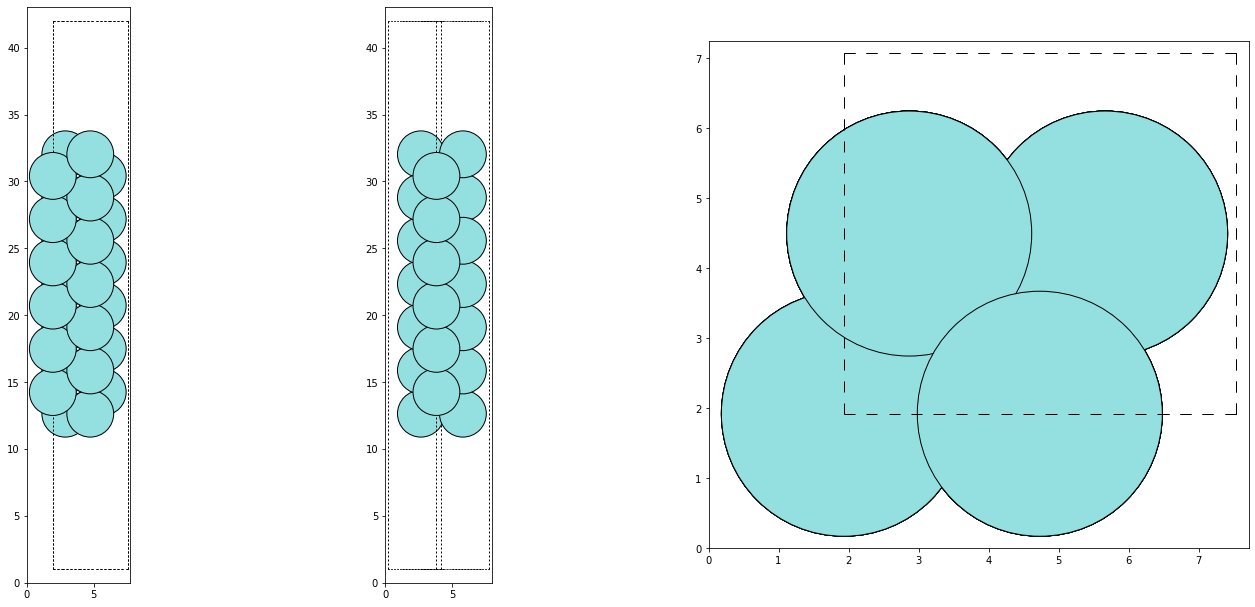

In [26]:
plotviews(Zr0101_2x2)

## zr1120

In [27]:
Zr1120 = surfaces_with_termination(zrhcp,[1,1,0], 7, vacuum=10, symmetric=True)[0]
Zr1120 = remove_bottom_atom(Zr1120)
Zr1120 = remove_bottom_atom(Zr1120)


([2, 3], ['Zr', 'Zr']) ([24, 25], ['Zr', 'Zr'])
([0, 1], ['Zr', 'Zr']) ([26, 27], ['Zr', 'Zr'])
([2, 3], ['Zr', 'Zr']) ([24, 25], ['Zr', 'Zr'])


(<Axes:>, <Axes:>, <Axes:>)

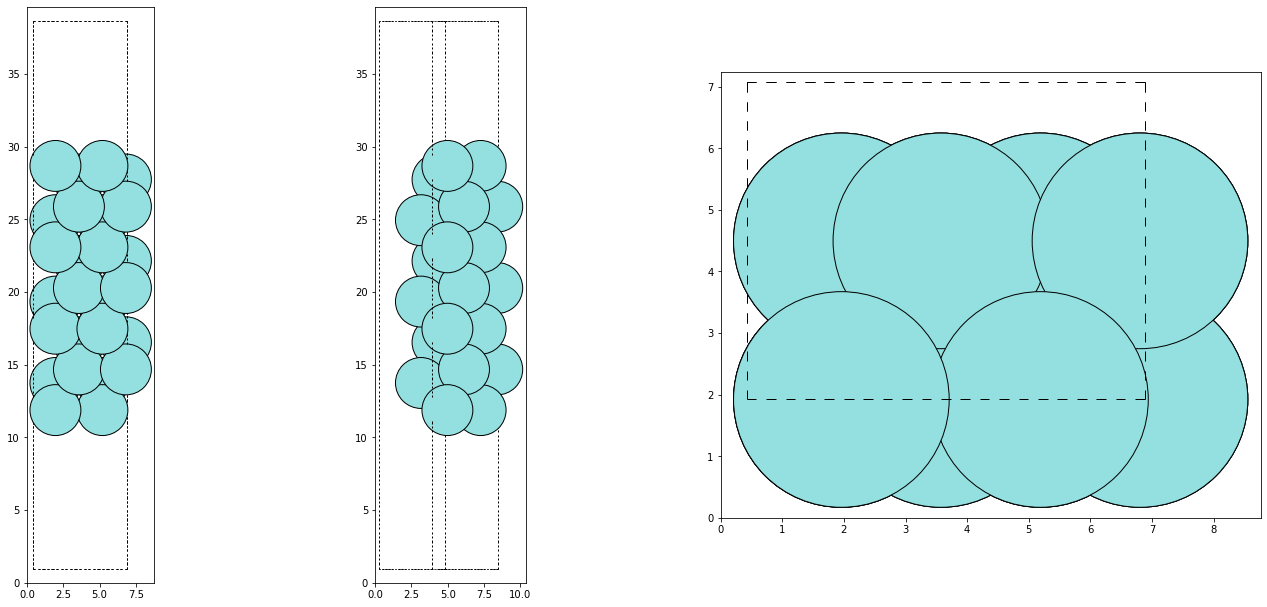

In [28]:
plotviews(Zr1120)

# Interfaces

Ok here is a tricky one. if you dont use a non linked cell in the `cell` option, this option is actually a pointer to the input var. this means that if you use atoms.cell and atoms is a slab to stack, this will totally mess the input atom and the output too. This also happens you you use no cell as imput because it assigns a pointer internally

In [29]:
Zr0101_2x2

Atoms(symbols='Zr26', pbc=[True, True, False], cell=[5.596775774497313, 5.1479, 41.00345])

In [30]:
ZrO2001_2x2[0].cell.copy()

Cell([7.268397980708341, 7.268397980708341, 50.22092905883963])

In [31]:
intfLayer = [stack(Zr0101_2x2, I, cell=I.cell.copy(), axis=2, distance=3, maxstrain=3,reorder=True) for I in ZrO2001_2x2]
saveintfs = [a.write( f'intf_zr0101_zro2_{i}.vasp', format='vasp',sort=True,  direct=True,  wrap=True) for i, a in enumerate(intfLayer)]

Optimization terminated successfully.
         Current function value: 4.452171
         Iterations: 298
         Function evaluations: 487
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 268
         Function evaluations: 429
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 278
         Function evaluations: 443
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 280
         Function evaluations: 439


[(<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>)]

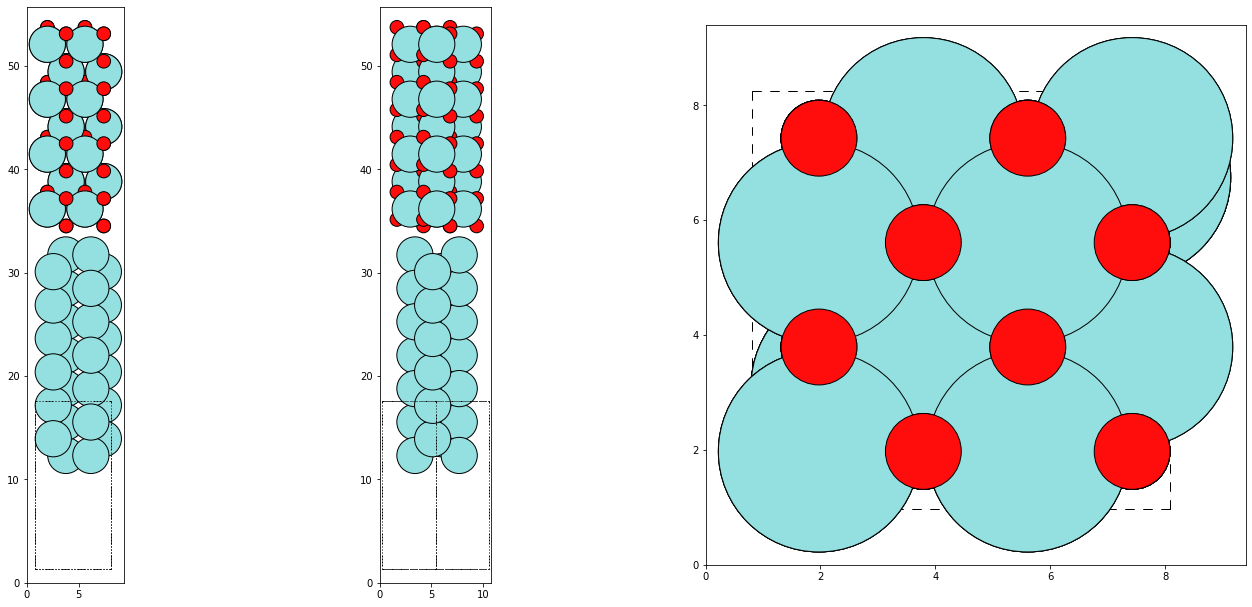

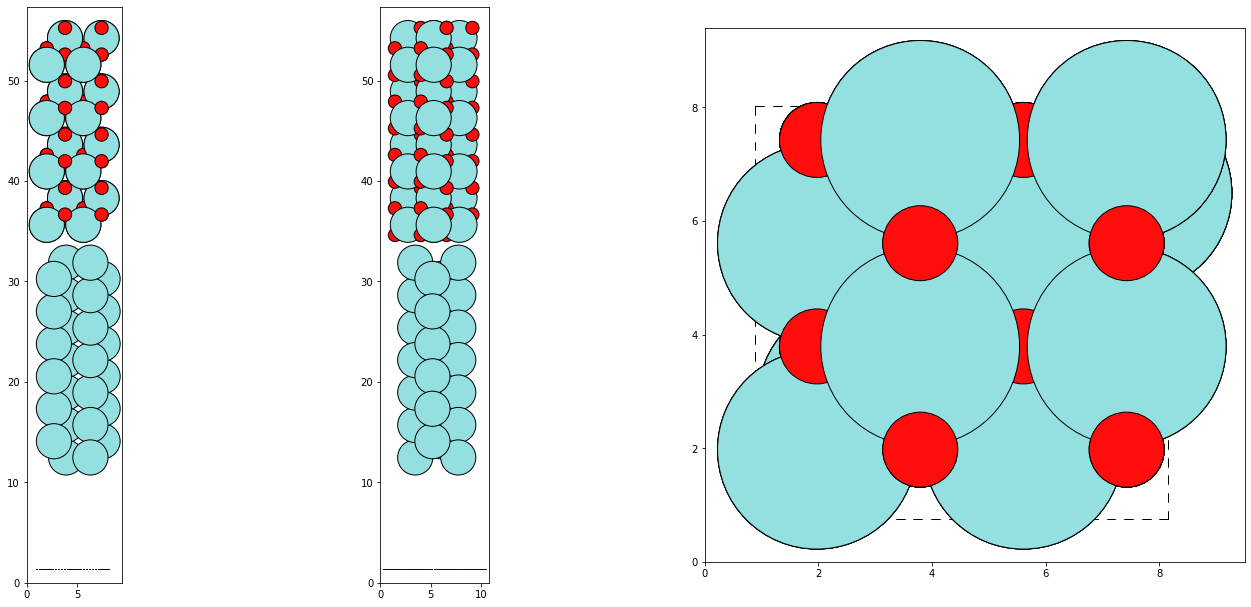

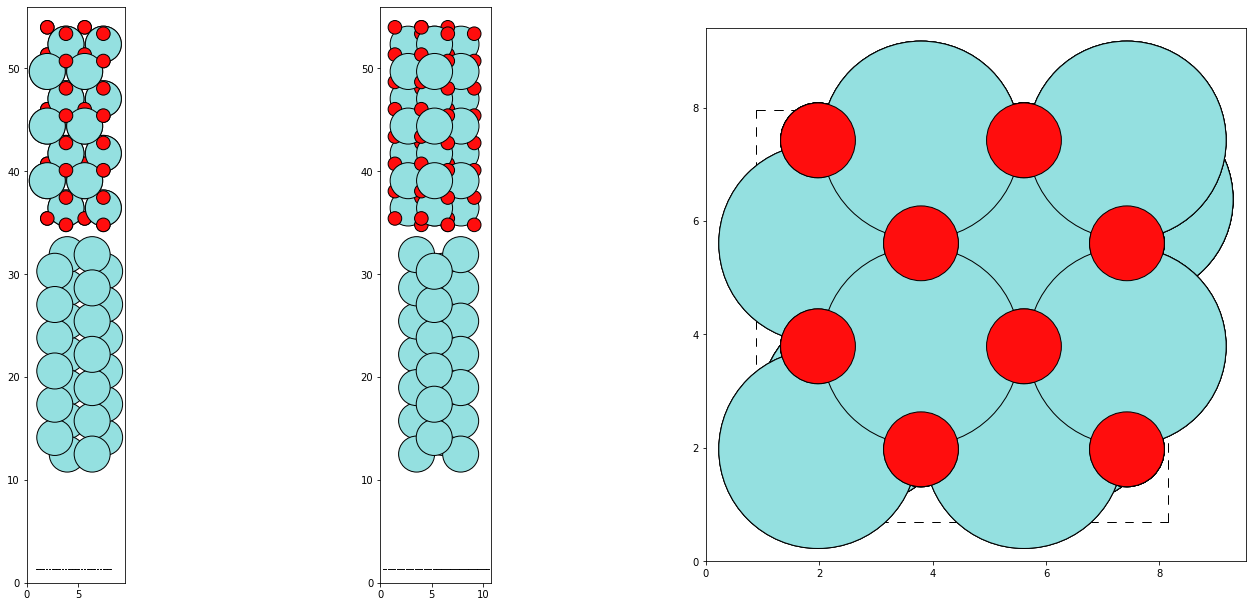

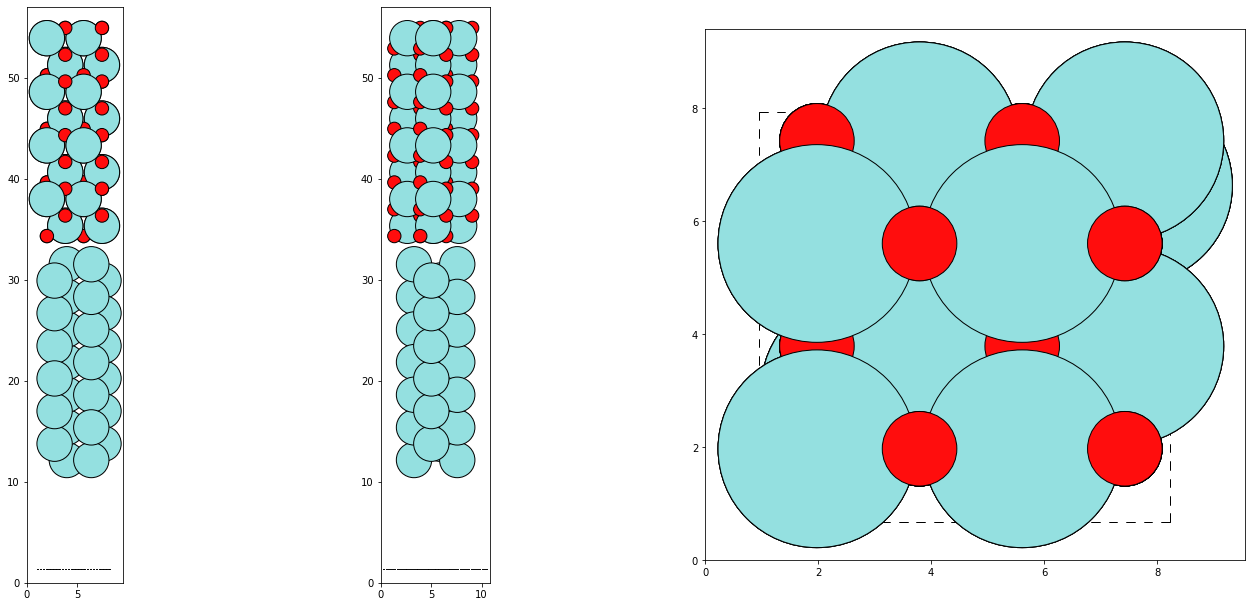

In [32]:
[plotviews(intf) for intf in intfLayer]

In [27]:
write('CandidateInterface001_1010hcp.vasp', intfLayer, format='vasp')

ValueError: vasp-format can only store 1 Atoms object.

In [ ]:
write('Interfaces/Layer_ZrO2.vasp', LayerZrO2)

In [ ]:
write('Interfaces/Layer_Zr1010.vasp', LayerZr1010)

Treated in vesta, can see a small probable coincidence at 2x4:
![coincidence]('Interfaces/Layer_Zr1010_coincidence.tiff')

In [ ]:
Interface = stack(Zr1010, oterm_zro2111x2,maxstrain=2, distance=2 )

In [ ]:
ax1, ax2,ax3 = plotviews(Interface)

In [ ]:
Interface.get_global_number_of_atoms()

In [ ]:
1/np.sqrt(26)

In [ ]:
5/np.sqrt(26)

# Stack

In [ ]:
STACKED = stack(oterm_zro2111x2, ZrHCP1010,maxstrain=1.0, distance=5.0)

In [ ]:
view(STACKED)

In [ ]:
STACKED.__dict__.keys()

In [ ]:
STACKED.__dict__['_cellobj']

In [ ]:
STACKED.cell

In [ ]:
ZrO2_super.cell

In [ ]:
ZrHCP1010.cell

In [ ]:
STACKED.get_global_number_of_atoms()

In [ ]:
view(ZrHCP1010)

In [ ]:
Zr.cell